In [1]:
#импорты
import numpy as np
import pandas as pd
import random
import os

import matplotlib
import matplotlib.pyplot as plt

#модуль содержит все функции библиотеки torch.nn
import torch #библиотека глубокого обучения
import torch.nn as nn #Библиотека нейронных сетей, глубоко интегрированная с autograd, разработанная для максимальной гибкости
import torch.nn.functional as F #модуль torch.nn.functional

#optim - это пакет, реализующий различные алгоритмы оптимизации. Наиболее часто используемые методы уже поддерживаются, 
#а интерфейс достаточно общий, чтобы в будущем можно было легко интегрировать более сложные методы.
import torch.optim as optim #модуль torch.optim


#В основе утилиты загрузки данных PyTorch лежит класс torch.utils.data.DataLoader.
#Он представляет собой итерацию Python по набору данных с поддержкой
from torch.utils.data import DataLoader

#Пакет torchvision состоит из популярных наборов данных, архитектур моделей 
#и общих преобразований изображений для компьютерного зрения.
from torchvision import datasets, transforms


In [2]:
# наличие cuda на компьютере?
from torch.cuda import is_available
is_available()

False

In [3]:
# какой device?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
    torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

In [5]:
seed = 42
random_state = seed

# Данные

In [6]:
#нормализация данных
mnist_transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
])
path = './MNIST_data'

In [7]:
batch_size = 8 #batch_size

In [8]:
ep = 20 #количество эпох = ep-1

In [9]:
#скачиваю данные
test_data = datasets.MNIST(path, train=False,
                           download=True, transform=mnist_transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False) 

train_data = datasets.MNIST(path, train=True,
                            download=True, transform=mnist_transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


# models base

In [10]:
#функция обучения train. Запускает одну эпоху
def train(models, loader, epoch, log=None):
    train_size = len(loader.sampler)
    for batch_idx, (data, target) in enumerate(loader): #итераруется по batch
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0: #каждый 200-ый batch в принт
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [11]:
#функция test
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, reduction='sum').item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c.to(torch.float) / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [12]:
#функция для отрисовки потерь и точности
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k)
                          for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.grid()
        plt.show()
        
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k)
                          for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.grid()
        plt.show()

In [13]:
lr =  1e-4*100

In [14]:
#нейронная сеть
class Net(nn.Module):
    def __init__(self,
                 batchnorm=False,
                 dropout=False,
                 lr=lr, l2=0.): #lr=1e-4*100
        super(Net, self).__init__()
        lr = lr
        # три линейных слоя
        self.fc1 = nn.Linear(28*28, 128) #на вход 28*28 (все признаки) на выходе 128
        self.fc2 = nn.Linear(128, 128) #на вход 128 на выходе 128
        self.fc3 = nn.Linear(128, 10) #на вход 128 на выходе 10 ("0","1"..."9")
        if batchnorm: # по умолчанию batchnorm=False (выключен)
            self.bn = nn.BatchNorm1d(128) #Batch-нормализация 128 - кол-во нейронов
        else:
            self.bn = lambda x: x
        if dropout: # по умолчанию dropout=False (выключен)
            self.dropout = nn.Dropout(0.2) #Dropout с какой вероятностью каждый нейрон будет удален (можно поставить 0.5)
        else:
            self.dropout = lambda x: x
        self.optim = optim.SGD(self.parameters(), lr=lr, weight_decay=l2) #оптимизатор SGD

    def forward(self, x): #функция forward. x - torch.Size([32, 1, 28, 28])
        x = x.view(-1, 28*28) #делает вектор из таблицы 28х28 
        x = F.relu(self.fc1(x)) #функция активации relu к слою fc1
        x = self.bn(x) #потом Batch-нормализация
        x = F.relu(self.fc2(x)) #функция активации relu к слою fc2
        x = self.dropout(x) #потомDropout
        x = self.fc3(x) #слой fc3
        x = F.log_softmax(x, dim=1) #функция log_softmax к выходу x (для того чтобы получить вероятность)
        return x

    def loss(self, output, target, **kwargs): #функция потерь
        self._loss = F.nll_loss(output, target, **kwargs)
        pred = output.data.max(1, keepdim=True)[1]
        t = target.data.view_as(pred)
        self._correct = pred.eq(t).to(torch.float).mean()
        return self._loss

In [15]:
#создаю модель
models = {'default': Net(lr = lr),
          'batchorm': Net(lr = lr, batchnorm=True),
          'dropout': Net(lr = lr, dropout=True),
          'batchnorm with dropout': Net(lr = lr, batchnorm=True, dropout=True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [16]:
# итерирование по эпохам
for epoch in range(1, ep): #для примера возьму ep эпох    
    for model in models.values():
        model.train() # для тренировки
    train(models, train_loader, epoch, train_log)
    for model in models.values():
        model.eval() # для тестирования
    test(models, test_loader, test_log)

Train Epoch: 1 [0/60000 (0%)]	Losses default: 2.280271 batchorm: 2.268279 dropout: 2.257278 batchnorm with dropout: 2.259130
Train Epoch: 1 [1600/60000 (3%)]	Losses default: 1.125240 batchorm: 1.036751 dropout: 1.252213 batchnorm with dropout: 1.112134
Train Epoch: 1 [3200/60000 (5%)]	Losses default: 0.567636 batchorm: 0.692656 dropout: 0.585012 batchnorm with dropout: 0.729732
Train Epoch: 1 [4800/60000 (8%)]	Losses default: 0.365623 batchorm: 1.034395 dropout: 0.442388 batchnorm with dropout: 1.065847
Train Epoch: 1 [6400/60000 (11%)]	Losses default: 0.513205 batchorm: 1.310327 dropout: 0.667383 batchnorm with dropout: 1.430713
Train Epoch: 1 [8000/60000 (13%)]	Losses default: 0.036312 batchorm: 0.083453 dropout: 0.082288 batchnorm with dropout: 0.088459
Train Epoch: 1 [9600/60000 (16%)]	Losses default: 0.352071 batchorm: 0.337564 dropout: 0.288138 batchnorm with dropout: 0.341666
Train Epoch: 1 [11200/60000 (19%)]	Losses default: 0.446105 batchorm: 0.558934 dropout: 0.496295 batchno

Train Epoch: 2 [36800/60000 (61%)]	Losses default: 0.020497 batchorm: 0.200584 dropout: 0.059727 batchnorm with dropout: 0.526377
Train Epoch: 2 [38400/60000 (64%)]	Losses default: 0.002250 batchorm: 0.043079 dropout: 0.001097 batchnorm with dropout: 0.015116
Train Epoch: 2 [40000/60000 (67%)]	Losses default: 0.003068 batchorm: 0.037162 dropout: 0.001535 batchnorm with dropout: 0.008845
Train Epoch: 2 [41600/60000 (69%)]	Losses default: 0.008791 batchorm: 0.024262 dropout: 0.010905 batchnorm with dropout: 0.152878
Train Epoch: 2 [43200/60000 (72%)]	Losses default: 0.002695 batchorm: 0.110565 dropout: 0.006379 batchnorm with dropout: 0.057314
Train Epoch: 2 [44800/60000 (75%)]	Losses default: 0.493059 batchorm: 1.195174 dropout: 0.590986 batchnorm with dropout: 1.112316
Train Epoch: 2 [46400/60000 (77%)]	Losses default: 0.008035 batchorm: 0.261088 dropout: 0.017204 batchnorm with dropout: 0.277046
Train Epoch: 2 [48000/60000 (80%)]	Losses default: 0.031773 batchorm: 0.046573 dropout: 0.

Train Epoch: 4 [8000/60000 (13%)]	Losses default: 0.001719 batchorm: 0.260887 dropout: 0.006939 batchnorm with dropout: 0.250582
Train Epoch: 4 [9600/60000 (16%)]	Losses default: 0.013071 batchorm: 0.058498 dropout: 0.023812 batchnorm with dropout: 0.010735
Train Epoch: 4 [11200/60000 (19%)]	Losses default: 0.014998 batchorm: 0.016604 dropout: 0.045271 batchnorm with dropout: 0.153360
Train Epoch: 4 [12800/60000 (21%)]	Losses default: 0.012026 batchorm: 0.143504 dropout: 0.007053 batchnorm with dropout: 0.191621
Train Epoch: 4 [14400/60000 (24%)]	Losses default: 0.074482 batchorm: 0.037453 dropout: 0.024999 batchnorm with dropout: 0.048664
Train Epoch: 4 [16000/60000 (27%)]	Losses default: 0.001917 batchorm: 0.002848 dropout: 0.000546 batchnorm with dropout: 0.025162
Train Epoch: 4 [17600/60000 (29%)]	Losses default: 0.015300 batchorm: 0.092556 dropout: 0.004635 batchnorm with dropout: 0.200069
Train Epoch: 4 [19200/60000 (32%)]	Losses default: 0.010827 batchorm: 0.549005 dropout: 0.09

Train Epoch: 5 [44800/60000 (75%)]	Losses default: 0.000400 batchorm: 0.009912 dropout: 0.006003 batchnorm with dropout: 0.013028
Train Epoch: 5 [46400/60000 (77%)]	Losses default: 0.004964 batchorm: 0.101235 dropout: 0.006023 batchnorm with dropout: 0.195346
Train Epoch: 5 [48000/60000 (80%)]	Losses default: 0.005506 batchorm: 0.110430 dropout: 0.009844 batchnorm with dropout: 0.120962
Train Epoch: 5 [49600/60000 (83%)]	Losses default: 0.015433 batchorm: 0.100897 dropout: 0.003321 batchnorm with dropout: 0.089864
Train Epoch: 5 [51200/60000 (85%)]	Losses default: 0.000185 batchorm: 0.041077 dropout: 0.001345 batchnorm with dropout: 0.034732
Train Epoch: 5 [52800/60000 (88%)]	Losses default: 0.025078 batchorm: 0.019191 dropout: 0.017879 batchnorm with dropout: 0.100720
Train Epoch: 5 [54400/60000 (91%)]	Losses default: 0.012846 batchorm: 0.081688 dropout: 0.021482 batchnorm with dropout: 0.451277
Train Epoch: 5 [56000/60000 (93%)]	Losses default: 0.123304 batchorm: 0.491617 dropout: 0.

Train Epoch: 7 [16000/60000 (27%)]	Losses default: 0.003392 batchorm: 0.006148 dropout: 0.003256 batchnorm with dropout: 0.016501
Train Epoch: 7 [17600/60000 (29%)]	Losses default: 0.000322 batchorm: 0.050466 dropout: 0.002922 batchnorm with dropout: 0.013183
Train Epoch: 7 [19200/60000 (32%)]	Losses default: 0.003466 batchorm: 0.087237 dropout: 0.073061 batchnorm with dropout: 0.195373
Train Epoch: 7 [20800/60000 (35%)]	Losses default: 0.055247 batchorm: 1.088490 dropout: 0.068162 batchnorm with dropout: 1.038683
Train Epoch: 7 [22400/60000 (37%)]	Losses default: 0.003923 batchorm: 0.264929 dropout: 0.004846 batchnorm with dropout: 0.256195
Train Epoch: 7 [24000/60000 (40%)]	Losses default: 0.003462 batchorm: 0.019140 dropout: 0.010824 batchnorm with dropout: 0.065834
Train Epoch: 7 [25600/60000 (43%)]	Losses default: 0.000769 batchorm: 0.025154 dropout: 0.002788 batchnorm with dropout: 0.141933
Train Epoch: 7 [27200/60000 (45%)]	Losses default: 0.001503 batchorm: 0.033866 dropout: 0.

Train Epoch: 8 [52800/60000 (88%)]	Losses default: 0.000316 batchorm: 0.005732 dropout: 0.000727 batchnorm with dropout: 0.047981
Train Epoch: 8 [54400/60000 (91%)]	Losses default: 0.001366 batchorm: 0.058317 dropout: 0.001995 batchnorm with dropout: 0.038559
Train Epoch: 8 [56000/60000 (93%)]	Losses default: 0.129654 batchorm: 0.608555 dropout: 0.200773 batchnorm with dropout: 0.131086
Train Epoch: 8 [57600/60000 (96%)]	Losses default: 0.000386 batchorm: 0.002689 dropout: 0.004655 batchnorm with dropout: 0.008871
Train Epoch: 8 [59200/60000 (99%)]	Losses default: 0.001136 batchorm: 0.124876 dropout: 0.031036 batchnorm with dropout: 0.026495
Train Epoch: 8 [60000/60000 (100%)]	Losses default: 0.001851 batchorm: 0.063791 dropout: 0.059566 batchnorm with dropout: 0.095263
Test set:
default: Loss: 0.0833	Accuracy: 9763.0/10000 (98%)
batchorm: Loss: 0.7805	Accuracy: 9738.0/10000 (97%)
dropout: Loss: 0.0683	Accuracy: 9791.0/10000 (98%)
batchnorm with dropout: Loss: 1.1350	Accuracy: 9627.0/1

Train Epoch: 10 [24000/60000 (40%)]	Losses default: 0.003267 batchorm: 0.019534 dropout: 0.002046 batchnorm with dropout: 0.028060
Train Epoch: 10 [25600/60000 (43%)]	Losses default: 0.002532 batchorm: 0.303193 dropout: 0.005404 batchnorm with dropout: 0.561965
Train Epoch: 10 [27200/60000 (45%)]	Losses default: 0.003210 batchorm: 0.127478 dropout: 0.002366 batchnorm with dropout: 0.218147
Train Epoch: 10 [28800/60000 (48%)]	Losses default: 0.000038 batchorm: 0.014085 dropout: 0.000083 batchnorm with dropout: 0.061239
Train Epoch: 10 [30400/60000 (51%)]	Losses default: 0.256195 batchorm: 0.117628 dropout: 0.046729 batchnorm with dropout: 0.460736
Train Epoch: 10 [32000/60000 (53%)]	Losses default: 0.000883 batchorm: 0.099319 dropout: 0.032749 batchnorm with dropout: 0.340734
Train Epoch: 10 [33600/60000 (56%)]	Losses default: 0.000057 batchorm: 0.001668 dropout: 0.000545 batchnorm with dropout: 0.006526
Train Epoch: 10 [35200/60000 (59%)]	Losses default: 0.002335 batchorm: 0.076703 dro

Train Epoch: 11 [59200/60000 (99%)]	Losses default: 0.000317 batchorm: 0.016558 dropout: 0.000058 batchnorm with dropout: 0.293091
Train Epoch: 11 [60000/60000 (100%)]	Losses default: 0.000011 batchorm: 0.068647 dropout: 0.000070 batchnorm with dropout: 0.039727
Test set:
default: Loss: 0.0818	Accuracy: 9787.0/10000 (98%)
batchorm: Loss: 1.0227	Accuracy: 9667.0/10000 (97%)
dropout: Loss: 0.0681	Accuracy: 9801.0/10000 (98%)
batchnorm with dropout: Loss: 0.9368	Accuracy: 9669.0/10000 (97%)

Train Epoch: 12 [0/60000 (0%)]	Losses default: 0.000624 batchorm: 0.032817 dropout: 0.003154 batchnorm with dropout: 0.050000
Train Epoch: 12 [1600/60000 (3%)]	Losses default: 0.006090 batchorm: 0.010898 dropout: 0.008990 batchnorm with dropout: 0.200332
Train Epoch: 12 [3200/60000 (5%)]	Losses default: 0.000105 batchorm: 0.004071 dropout: 0.000374 batchnorm with dropout: 0.042290
Train Epoch: 12 [4800/60000 (8%)]	Losses default: 0.000087 batchorm: 0.027393 dropout: 0.001397 batchnorm with dropout: 0.

Train Epoch: 13 [30400/60000 (51%)]	Losses default: 0.001257 batchorm: 0.009419 dropout: 0.003597 batchnorm with dropout: 0.096358
Train Epoch: 13 [32000/60000 (53%)]	Losses default: 0.001474 batchorm: 0.027968 dropout: 0.000351 batchnorm with dropout: 0.219686
Train Epoch: 13 [33600/60000 (56%)]	Losses default: 0.000040 batchorm: 0.002590 dropout: 0.001252 batchnorm with dropout: 0.018969
Train Epoch: 13 [35200/60000 (59%)]	Losses default: 0.001158 batchorm: 0.249650 dropout: 0.000304 batchnorm with dropout: 0.486148
Train Epoch: 13 [36800/60000 (61%)]	Losses default: 0.011069 batchorm: 0.563266 dropout: 0.007813 batchnorm with dropout: 0.736617
Train Epoch: 13 [38400/60000 (64%)]	Losses default: 0.024079 batchorm: 0.070354 dropout: 0.002874 batchnorm with dropout: 0.059994
Train Epoch: 13 [40000/60000 (67%)]	Losses default: 0.000230 batchorm: 0.305920 dropout: 0.001902 batchnorm with dropout: 0.831108
Train Epoch: 13 [41600/60000 (69%)]	Losses default: 0.000088 batchorm: 0.025211 dro

Train Epoch: 15 [1600/60000 (3%)]	Losses default: 0.000001 batchorm: 0.001175 dropout: 0.000140 batchnorm with dropout: 0.007871
Train Epoch: 15 [3200/60000 (5%)]	Losses default: 0.000058 batchorm: 0.015679 dropout: 0.000014 batchnorm with dropout: 0.011501
Train Epoch: 15 [4800/60000 (8%)]	Losses default: 0.000027 batchorm: 0.000932 dropout: 0.000791 batchnorm with dropout: 0.003668
Train Epoch: 15 [6400/60000 (11%)]	Losses default: 0.000252 batchorm: 0.007315 dropout: 0.001291 batchnorm with dropout: 0.024713
Train Epoch: 15 [8000/60000 (13%)]	Losses default: 0.000853 batchorm: 0.006534 dropout: 0.005675 batchnorm with dropout: 0.151579
Train Epoch: 15 [9600/60000 (16%)]	Losses default: 0.000023 batchorm: 0.001316 dropout: 0.000018 batchnorm with dropout: 0.005900
Train Epoch: 15 [11200/60000 (19%)]	Losses default: 0.000010 batchorm: 0.016328 dropout: 0.000534 batchnorm with dropout: 0.006972
Train Epoch: 15 [12800/60000 (21%)]	Losses default: 0.000073 batchorm: 0.001753 dropout: 0.0

Train Epoch: 16 [36800/60000 (61%)]	Losses default: 0.009482 batchorm: 0.005878 dropout: 0.049302 batchnorm with dropout: 0.010837
Train Epoch: 16 [38400/60000 (64%)]	Losses default: 0.003516 batchorm: 0.004860 dropout: 0.010928 batchnorm with dropout: 0.025645
Train Epoch: 16 [40000/60000 (67%)]	Losses default: 0.001396 batchorm: 0.002888 dropout: 0.002267 batchnorm with dropout: 0.010496
Train Epoch: 16 [41600/60000 (69%)]	Losses default: 0.004877 batchorm: 0.141614 dropout: 0.042217 batchnorm with dropout: 0.497001
Train Epoch: 16 [43200/60000 (72%)]	Losses default: 0.000169 batchorm: 0.005070 dropout: 0.010759 batchnorm with dropout: 0.003836
Train Epoch: 16 [44800/60000 (75%)]	Losses default: 0.000001 batchorm: 0.015721 dropout: 0.000231 batchnorm with dropout: 0.017186
Train Epoch: 16 [46400/60000 (77%)]	Losses default: 0.002044 batchorm: 0.003012 dropout: 0.000112 batchnorm with dropout: 0.007462
Train Epoch: 16 [48000/60000 (80%)]	Losses default: 0.000612 batchorm: 0.062631 dro

Train Epoch: 18 [8000/60000 (13%)]	Losses default: 0.000035 batchorm: 0.000714 dropout: 0.000530 batchnorm with dropout: 0.004343
Train Epoch: 18 [9600/60000 (16%)]	Losses default: 0.000001 batchorm: 0.006762 dropout: 0.000014 batchnorm with dropout: 0.022530
Train Epoch: 18 [11200/60000 (19%)]	Losses default: 0.001847 batchorm: 0.072488 dropout: 0.003474 batchnorm with dropout: 0.015308
Train Epoch: 18 [12800/60000 (21%)]	Losses default: 0.000004 batchorm: 0.007582 dropout: 0.000611 batchnorm with dropout: 0.102097
Train Epoch: 18 [14400/60000 (24%)]	Losses default: 0.000047 batchorm: 0.001078 dropout: 0.011423 batchnorm with dropout: 0.010212
Train Epoch: 18 [16000/60000 (27%)]	Losses default: 0.000133 batchorm: 0.002580 dropout: 0.001039 batchnorm with dropout: 0.375795
Train Epoch: 18 [17600/60000 (29%)]	Losses default: 0.001349 batchorm: 0.506543 dropout: 0.008555 batchnorm with dropout: 0.499288
Train Epoch: 18 [19200/60000 (32%)]	Losses default: 0.000110 batchorm: 0.016847 dropo

Train Epoch: 19 [43200/60000 (72%)]	Losses default: 0.005936 batchorm: 0.112904 dropout: 0.000944 batchnorm with dropout: 0.247273
Train Epoch: 19 [44800/60000 (75%)]	Losses default: 0.000012 batchorm: 0.054584 dropout: 0.000082 batchnorm with dropout: 0.060668
Train Epoch: 19 [46400/60000 (77%)]	Losses default: 0.000006 batchorm: 0.000488 dropout: 0.000891 batchnorm with dropout: 0.018848
Train Epoch: 19 [48000/60000 (80%)]	Losses default: 0.000008 batchorm: 0.012994 dropout: 0.000002 batchnorm with dropout: 0.010133
Train Epoch: 19 [49600/60000 (83%)]	Losses default: 0.000462 batchorm: 0.055172 dropout: 0.001953 batchnorm with dropout: 0.026578
Train Epoch: 19 [51200/60000 (85%)]	Losses default: 0.000856 batchorm: 0.225380 dropout: 0.000035 batchnorm with dropout: 0.108474
Train Epoch: 19 [52800/60000 (88%)]	Losses default: 0.000024 batchorm: 0.000489 dropout: 0.000965 batchnorm with dropout: 0.002234
Train Epoch: 19 [54400/60000 (91%)]	Losses default: 0.000399 batchorm: 0.004236 dro

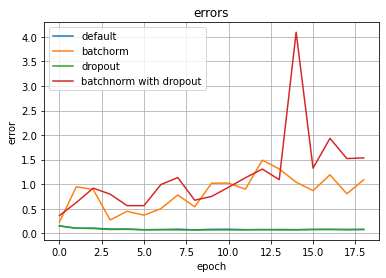

In [17]:
# отрисую
plot_graphs(test_log, 'loss')

<AxesSubplot:>

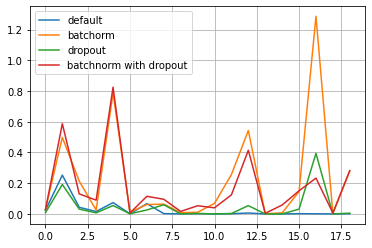

In [18]:
# отрисую train_log (plot_graphs(train_log, 'loss') не работает :( )
def df_get(df_key, data):
    train_log_list = []
    data = data
    df_key = df_key
    for el in data[df_key]:
        train_log_list.append(el[0].detach().numpy())
        df = pd.DataFrame(train_log_list)
    df.columns = [df_key]
    return df

df_default = df_get(df_key = 'default', data = train_log)
df_batchorm = df_get(df_key = 'batchorm', data = train_log)
df_dropout = df_get(df_key = 'dropout', data = train_log)
df_batchnorm_with_dropout = df_get(df_key = 'batchnorm with dropout', data = train_log)

pd.concat([df_default, df_batchorm, df_dropout, df_batchnorm_with_dropout], axis = 1).plot(grid=True)

## большой Lerning rate ускорил обучение, но ухудшил результаты на тесте

# уменьшаю Lerning rate в 100/10 раз

In [19]:
#создаю модель
lr =  1e-4*100/10
models = {'default': Net(lr = lr),
          'batchorm': Net(lr = lr, batchnorm=True),
          'dropout': Net(lr = lr, dropout=True),
          'batchnorm with dropout': Net(lr = lr, batchnorm=True, dropout=True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [20]:
# итерирование по эпохам
for epoch in range(1, ep): #для примера возьму ep эпох    
    for model in models.values():
        model.train() # для тренировки
    train(models, train_loader, epoch, train_log)
    for model in models.values():
        model.eval() # для тестирования
    test(models, test_loader, test_log)

Train Epoch: 1 [0/60000 (0%)]	Losses default: 2.340087 batchorm: 2.369217 dropout: 2.387166 batchnorm with dropout: 2.404097
Train Epoch: 1 [1600/60000 (3%)]	Losses default: 2.289968 batchorm: 2.128800 dropout: 2.323392 batchnorm with dropout: 2.172893
Train Epoch: 1 [3200/60000 (5%)]	Losses default: 2.195083 batchorm: 1.780713 dropout: 2.154293 batchnorm with dropout: 1.758209
Train Epoch: 1 [4800/60000 (8%)]	Losses default: 2.123877 batchorm: 1.638381 dropout: 2.159908 batchnorm with dropout: 1.681289
Train Epoch: 1 [6400/60000 (11%)]	Losses default: 2.046694 batchorm: 1.593217 dropout: 2.049380 batchnorm with dropout: 1.603843
Train Epoch: 1 [8000/60000 (13%)]	Losses default: 1.858823 batchorm: 1.316616 dropout: 2.058501 batchnorm with dropout: 1.275023
Train Epoch: 1 [9600/60000 (16%)]	Losses default: 1.550590 batchorm: 0.854822 dropout: 1.727152 batchnorm with dropout: 0.952146
Train Epoch: 1 [11200/60000 (19%)]	Losses default: 1.505328 batchorm: 1.042330 dropout: 1.629839 batchno

Train Epoch: 2 [36800/60000 (61%)]	Losses default: 0.615208 batchorm: 0.414739 dropout: 0.755274 batchnorm with dropout: 0.334899
Train Epoch: 2 [38400/60000 (64%)]	Losses default: 0.139265 batchorm: 0.123867 dropout: 0.341959 batchnorm with dropout: 0.164355
Train Epoch: 2 [40000/60000 (67%)]	Losses default: 0.200150 batchorm: 0.192805 dropout: 0.279288 batchnorm with dropout: 0.230788
Train Epoch: 2 [41600/60000 (69%)]	Losses default: 0.133823 batchorm: 0.073579 dropout: 0.183679 batchnorm with dropout: 0.096000
Train Epoch: 2 [43200/60000 (72%)]	Losses default: 0.710396 batchorm: 0.788540 dropout: 0.865362 batchnorm with dropout: 0.670100
Train Epoch: 2 [44800/60000 (75%)]	Losses default: 0.089534 batchorm: 0.166468 dropout: 0.089865 batchnorm with dropout: 0.214229
Train Epoch: 2 [46400/60000 (77%)]	Losses default: 0.125554 batchorm: 0.452775 dropout: 0.163925 batchnorm with dropout: 0.500208
Train Epoch: 2 [48000/60000 (80%)]	Losses default: 0.287641 batchorm: 0.100797 dropout: 0.

Train Epoch: 4 [8000/60000 (13%)]	Losses default: 0.541293 batchorm: 0.352769 dropout: 0.385565 batchnorm with dropout: 0.510292
Train Epoch: 4 [9600/60000 (16%)]	Losses default: 0.391215 batchorm: 0.869704 dropout: 0.447277 batchnorm with dropout: 0.845724
Train Epoch: 4 [11200/60000 (19%)]	Losses default: 0.052614 batchorm: 0.047951 dropout: 0.053259 batchnorm with dropout: 0.082252
Train Epoch: 4 [12800/60000 (21%)]	Losses default: 0.462284 batchorm: 0.287431 dropout: 0.397035 batchnorm with dropout: 0.407423
Train Epoch: 4 [14400/60000 (24%)]	Losses default: 0.126387 batchorm: 0.230724 dropout: 0.200491 batchnorm with dropout: 0.130351
Train Epoch: 4 [16000/60000 (27%)]	Losses default: 0.209230 batchorm: 0.409037 dropout: 0.332134 batchnorm with dropout: 0.716520
Train Epoch: 4 [17600/60000 (29%)]	Losses default: 0.121015 batchorm: 0.095466 dropout: 0.188948 batchnorm with dropout: 0.202675
Train Epoch: 4 [19200/60000 (32%)]	Losses default: 0.831454 batchorm: 0.345716 dropout: 0.52

Train Epoch: 5 [44800/60000 (75%)]	Losses default: 0.137232 batchorm: 0.375797 dropout: 0.110142 batchnorm with dropout: 0.927360
Train Epoch: 5 [46400/60000 (77%)]	Losses default: 0.378622 batchorm: 0.524215 dropout: 0.412712 batchnorm with dropout: 0.659027
Train Epoch: 5 [48000/60000 (80%)]	Losses default: 0.014987 batchorm: 0.027455 dropout: 0.023605 batchnorm with dropout: 0.063745
Train Epoch: 5 [49600/60000 (83%)]	Losses default: 0.244998 batchorm: 0.362293 dropout: 0.235020 batchnorm with dropout: 0.452873
Train Epoch: 5 [51200/60000 (85%)]	Losses default: 0.170753 batchorm: 0.087471 dropout: 0.038841 batchnorm with dropout: 0.073360
Train Epoch: 5 [52800/60000 (88%)]	Losses default: 0.060803 batchorm: 0.174296 dropout: 0.053874 batchnorm with dropout: 0.338231
Train Epoch: 5 [54400/60000 (91%)]	Losses default: 0.050704 batchorm: 0.012056 dropout: 0.059965 batchnorm with dropout: 0.014910
Train Epoch: 5 [56000/60000 (93%)]	Losses default: 0.760051 batchorm: 0.450994 dropout: 0.

Train Epoch: 7 [16000/60000 (27%)]	Losses default: 0.120753 batchorm: 0.840620 dropout: 0.220215 batchnorm with dropout: 0.660867
Train Epoch: 7 [17600/60000 (29%)]	Losses default: 0.055915 batchorm: 0.157141 dropout: 0.106947 batchnorm with dropout: 0.260684
Train Epoch: 7 [19200/60000 (32%)]	Losses default: 0.763457 batchorm: 1.133630 dropout: 0.799897 batchnorm with dropout: 1.102357
Train Epoch: 7 [20800/60000 (35%)]	Losses default: 0.068552 batchorm: 0.058723 dropout: 0.093956 batchnorm with dropout: 0.122107
Train Epoch: 7 [22400/60000 (37%)]	Losses default: 0.112140 batchorm: 0.481129 dropout: 0.301480 batchnorm with dropout: 0.254732
Train Epoch: 7 [24000/60000 (40%)]	Losses default: 0.034617 batchorm: 0.099858 dropout: 0.041528 batchnorm with dropout: 0.067061
Train Epoch: 7 [25600/60000 (43%)]	Losses default: 0.012081 batchorm: 0.046973 dropout: 0.029981 batchnorm with dropout: 0.057404
Train Epoch: 7 [27200/60000 (45%)]	Losses default: 0.050355 batchorm: 0.083618 dropout: 0.

Train Epoch: 8 [52800/60000 (88%)]	Losses default: 0.086558 batchorm: 0.051879 dropout: 0.152827 batchnorm with dropout: 0.088365
Train Epoch: 8 [54400/60000 (91%)]	Losses default: 0.045269 batchorm: 0.073737 dropout: 0.027472 batchnorm with dropout: 0.071186
Train Epoch: 8 [56000/60000 (93%)]	Losses default: 0.167171 batchorm: 0.226882 dropout: 0.156981 batchnorm with dropout: 0.862163
Train Epoch: 8 [57600/60000 (96%)]	Losses default: 0.511236 batchorm: 0.730520 dropout: 0.480026 batchnorm with dropout: 0.798720
Train Epoch: 8 [59200/60000 (99%)]	Losses default: 0.036256 batchorm: 0.155488 dropout: 0.034567 batchnorm with dropout: 0.066460
Train Epoch: 8 [60000/60000 (100%)]	Losses default: 0.137935 batchorm: 0.119865 dropout: 0.257930 batchnorm with dropout: 0.343774
Test set:
default: Loss: 0.1468	Accuracy: 9565.0/10000 (96%)
batchorm: Loss: 0.2043	Accuracy: 9552.0/10000 (96%)
dropout: Loss: 0.1539	Accuracy: 9538.0/10000 (95%)
batchnorm with dropout: Loss: 0.2433	Accuracy: 9537.0/1

Train Epoch: 10 [24000/60000 (40%)]	Losses default: 0.044243 batchorm: 0.165631 dropout: 0.115314 batchnorm with dropout: 0.076438
Train Epoch: 10 [25600/60000 (43%)]	Losses default: 0.104546 batchorm: 0.022440 dropout: 0.092833 batchnorm with dropout: 0.013299
Train Epoch: 10 [27200/60000 (45%)]	Losses default: 0.318903 batchorm: 0.089708 dropout: 0.358877 batchnorm with dropout: 0.078459
Train Epoch: 10 [28800/60000 (48%)]	Losses default: 0.011018 batchorm: 0.053627 dropout: 0.059276 batchnorm with dropout: 0.034159
Train Epoch: 10 [30400/60000 (51%)]	Losses default: 0.042526 batchorm: 0.200401 dropout: 0.124512 batchnorm with dropout: 0.143998
Train Epoch: 10 [32000/60000 (53%)]	Losses default: 0.185504 batchorm: 0.171165 dropout: 0.466390 batchnorm with dropout: 0.071460
Train Epoch: 10 [33600/60000 (56%)]	Losses default: 0.048437 batchorm: 0.014363 dropout: 0.056505 batchnorm with dropout: 0.029407
Train Epoch: 10 [35200/60000 (59%)]	Losses default: 0.067526 batchorm: 0.095297 dro

Train Epoch: 11 [59200/60000 (99%)]	Losses default: 0.018315 batchorm: 0.191171 dropout: 0.031200 batchnorm with dropout: 0.533932
Train Epoch: 11 [60000/60000 (100%)]	Losses default: 0.224143 batchorm: 0.187526 dropout: 0.300732 batchnorm with dropout: 0.203012
Test set:
default: Loss: 0.1202	Accuracy: 9650.0/10000 (96%)
batchorm: Loss: 0.1973	Accuracy: 9593.0/10000 (96%)
dropout: Loss: 0.1281	Accuracy: 9606.0/10000 (96%)
batchnorm with dropout: Loss: 0.2051	Accuracy: 9564.0/10000 (96%)

Train Epoch: 12 [0/60000 (0%)]	Losses default: 0.019875 batchorm: 0.016406 dropout: 0.054470 batchnorm with dropout: 0.029507
Train Epoch: 12 [1600/60000 (3%)]	Losses default: 0.278089 batchorm: 0.842916 dropout: 0.652819 batchnorm with dropout: 0.729265
Train Epoch: 12 [3200/60000 (5%)]	Losses default: 0.006159 batchorm: 0.092810 dropout: 0.006313 batchnorm with dropout: 0.069929
Train Epoch: 12 [4800/60000 (8%)]	Losses default: 0.189873 batchorm: 0.308490 dropout: 0.072051 batchnorm with dropout: 0.

Train Epoch: 13 [30400/60000 (51%)]	Losses default: 0.035001 batchorm: 0.247918 dropout: 0.021136 batchnorm with dropout: 0.139861
Train Epoch: 13 [32000/60000 (53%)]	Losses default: 0.081315 batchorm: 0.071201 dropout: 0.180028 batchnorm with dropout: 0.082692
Train Epoch: 13 [33600/60000 (56%)]	Losses default: 0.009518 batchorm: 0.039729 dropout: 0.018415 batchnorm with dropout: 0.045327
Train Epoch: 13 [35200/60000 (59%)]	Losses default: 0.003497 batchorm: 0.021838 dropout: 0.016841 batchnorm with dropout: 0.013124
Train Epoch: 13 [36800/60000 (61%)]	Losses default: 0.015941 batchorm: 0.015863 dropout: 0.021048 batchnorm with dropout: 0.029369
Train Epoch: 13 [38400/60000 (64%)]	Losses default: 0.056553 batchorm: 0.385645 dropout: 0.025774 batchnorm with dropout: 0.158185
Train Epoch: 13 [40000/60000 (67%)]	Losses default: 0.033115 batchorm: 0.018547 dropout: 0.043664 batchnorm with dropout: 0.053217
Train Epoch: 13 [41600/60000 (69%)]	Losses default: 0.091931 batchorm: 0.265154 dro

Train Epoch: 15 [1600/60000 (3%)]	Losses default: 0.069037 batchorm: 0.111843 dropout: 0.185813 batchnorm with dropout: 0.097227
Train Epoch: 15 [3200/60000 (5%)]	Losses default: 0.260493 batchorm: 0.180889 dropout: 0.197240 batchnorm with dropout: 0.663541
Train Epoch: 15 [4800/60000 (8%)]	Losses default: 0.007079 batchorm: 0.039639 dropout: 0.012366 batchnorm with dropout: 0.011915
Train Epoch: 15 [6400/60000 (11%)]	Losses default: 0.183433 batchorm: 0.040241 dropout: 0.118152 batchnorm with dropout: 0.053699
Train Epoch: 15 [8000/60000 (13%)]	Losses default: 0.003365 batchorm: 0.006342 dropout: 0.004504 batchnorm with dropout: 0.004148
Train Epoch: 15 [9600/60000 (16%)]	Losses default: 0.073297 batchorm: 0.286155 dropout: 0.028814 batchnorm with dropout: 0.062411
Train Epoch: 15 [11200/60000 (19%)]	Losses default: 0.052037 batchorm: 0.004845 dropout: 0.152687 batchnorm with dropout: 0.053793
Train Epoch: 15 [12800/60000 (21%)]	Losses default: 0.070857 batchorm: 0.856226 dropout: 0.0

Train Epoch: 16 [36800/60000 (61%)]	Losses default: 0.023547 batchorm: 0.029436 dropout: 0.024452 batchnorm with dropout: 0.324666
Train Epoch: 16 [38400/60000 (64%)]	Losses default: 0.022628 batchorm: 0.041114 dropout: 0.025043 batchnorm with dropout: 0.060504
Train Epoch: 16 [40000/60000 (67%)]	Losses default: 0.003225 batchorm: 0.018518 dropout: 0.004448 batchnorm with dropout: 0.033029
Train Epoch: 16 [41600/60000 (69%)]	Losses default: 0.021884 batchorm: 0.097171 dropout: 0.047035 batchnorm with dropout: 0.093699
Train Epoch: 16 [43200/60000 (72%)]	Losses default: 0.006197 batchorm: 0.299942 dropout: 0.045030 batchnorm with dropout: 0.204229
Train Epoch: 16 [44800/60000 (75%)]	Losses default: 0.027960 batchorm: 0.049903 dropout: 0.011035 batchnorm with dropout: 0.111137
Train Epoch: 16 [46400/60000 (77%)]	Losses default: 0.012052 batchorm: 0.013740 dropout: 0.024466 batchnorm with dropout: 0.067199
Train Epoch: 16 [48000/60000 (80%)]	Losses default: 0.205712 batchorm: 1.144791 dro

Train Epoch: 18 [8000/60000 (13%)]	Losses default: 0.008027 batchorm: 0.079009 dropout: 0.010308 batchnorm with dropout: 0.085435
Train Epoch: 18 [9600/60000 (16%)]	Losses default: 0.006448 batchorm: 0.019956 dropout: 0.017299 batchnorm with dropout: 0.125940
Train Epoch: 18 [11200/60000 (19%)]	Losses default: 0.004842 batchorm: 0.022091 dropout: 0.012438 batchnorm with dropout: 0.093732
Train Epoch: 18 [12800/60000 (21%)]	Losses default: 0.016621 batchorm: 0.038761 dropout: 0.024942 batchnorm with dropout: 0.291482
Train Epoch: 18 [14400/60000 (24%)]	Losses default: 0.006368 batchorm: 0.260833 dropout: 0.009486 batchnorm with dropout: 0.183498
Train Epoch: 18 [16000/60000 (27%)]	Losses default: 0.266244 batchorm: 0.310837 dropout: 0.247174 batchnorm with dropout: 0.487824
Train Epoch: 18 [17600/60000 (29%)]	Losses default: 0.079596 batchorm: 0.171194 dropout: 0.048685 batchnorm with dropout: 0.112956
Train Epoch: 18 [19200/60000 (32%)]	Losses default: 0.636488 batchorm: 1.419188 dropo

Train Epoch: 19 [43200/60000 (72%)]	Losses default: 0.007435 batchorm: 0.004477 dropout: 0.024529 batchnorm with dropout: 0.008295
Train Epoch: 19 [44800/60000 (75%)]	Losses default: 0.087763 batchorm: 0.126660 dropout: 0.225718 batchnorm with dropout: 0.287023
Train Epoch: 19 [46400/60000 (77%)]	Losses default: 0.002800 batchorm: 0.017413 dropout: 0.003880 batchnorm with dropout: 0.010767
Train Epoch: 19 [48000/60000 (80%)]	Losses default: 0.019615 batchorm: 0.055144 dropout: 0.011545 batchnorm with dropout: 0.340757
Train Epoch: 19 [49600/60000 (83%)]	Losses default: 0.002585 batchorm: 0.518143 dropout: 0.003159 batchnorm with dropout: 0.739092
Train Epoch: 19 [51200/60000 (85%)]	Losses default: 0.006041 batchorm: 0.018090 dropout: 0.026579 batchnorm with dropout: 0.010262
Train Epoch: 19 [52800/60000 (88%)]	Losses default: 0.014745 batchorm: 0.130289 dropout: 0.031650 batchnorm with dropout: 0.126715
Train Epoch: 19 [54400/60000 (91%)]	Losses default: 0.001639 batchorm: 0.030143 dro

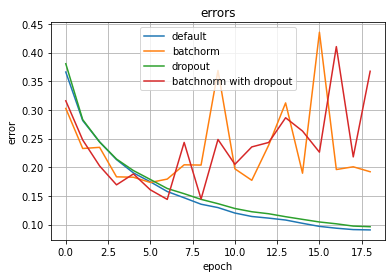

In [21]:
# отрисую
plot_graphs(test_log, 'loss')

<AxesSubplot:>

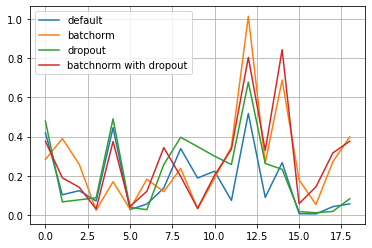

In [22]:
# отрисую train_log (plot_graphs(train_log, 'loss') не работает :( )
def df_get(df_key, data):
    train_log_list = []
    data = data
    df_key = df_key
    for el in data[df_key]:
        train_log_list.append(el[0].detach().numpy())
        df = pd.DataFrame(train_log_list)
    df.columns = [df_key]
    return df

df_default = df_get(df_key = 'default', data = train_log)
df_batchorm = df_get(df_key = 'batchorm', data = train_log)
df_dropout = df_get(df_key = 'dropout', data = train_log)
df_batchnorm_with_dropout = df_get(df_key = 'batchnorm with dropout', data = train_log)

pd.concat([df_default, df_batchorm, df_dropout, df_batchnorm_with_dropout], axis = 1).plot(grid=True)

## Вывод: 'default', 'dropout' в норме; 'batchorm', 'batchnorm with dropout' overfitting 

# увеличиваю batch_size в 4 раза раза, lr =  1e-4*100/100

In [23]:
batch_size = 8*(2**2) #batch_size

In [24]:
test_data = datasets.MNIST(path, train=False,
                           download=True, transform=mnist_transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False) 

train_data = datasets.MNIST(path, train=True,
                            download=True, transform=mnist_transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [25]:
#создаю модель
lr =  1e-4*100/100
models = {'default': Net(lr = lr),
          'batchorm': Net(lr = lr, batchnorm=True),
          'dropout': Net(lr = lr, dropout=True),
          'batchnorm with dropout': Net(lr = lr, batchnorm=True, dropout=True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [26]:
# итерирование по эпохам
for epoch in range(1, ep): #для примера возьму ep эпох    
    for model in models.values():
        model.train() # для тренировки
    train(models, train_loader, epoch, train_log)
    for model in models.values():
        model.eval() # для тестирования
    test(models, test_loader, test_log)

Train Epoch: 1 [0/60000 (0%)]	Losses default: 2.279679 batchorm: 2.323079 dropout: 2.304144 batchnorm with dropout: 2.310121
Train Epoch: 1 [6400/60000 (11%)]	Losses default: 2.305589 batchorm: 2.298481 dropout: 2.291284 batchnorm with dropout: 2.261741
Train Epoch: 1 [12800/60000 (21%)]	Losses default: 2.315359 batchorm: 2.242883 dropout: 2.286745 batchnorm with dropout: 2.319926
Train Epoch: 1 [19200/60000 (32%)]	Losses default: 2.280412 batchorm: 2.245239 dropout: 2.283327 batchnorm with dropout: 2.163475
Train Epoch: 1 [25600/60000 (43%)]	Losses default: 2.277066 batchorm: 2.058754 dropout: 2.269524 batchnorm with dropout: 2.176720
Train Epoch: 1 [32000/60000 (53%)]	Losses default: 2.297117 batchorm: 2.142121 dropout: 2.266814 batchnorm with dropout: 2.179424
Train Epoch: 1 [38400/60000 (64%)]	Losses default: 2.275391 batchorm: 2.052985 dropout: 2.258096 batchnorm with dropout: 2.021438
Train Epoch: 1 [44800/60000 (75%)]	Losses default: 2.266891 batchorm: 2.100755 dropout: 2.253569

Train Epoch: 6 [6400/60000 (11%)]	Losses default: 1.902103 batchorm: 1.090670 dropout: 1.864681 batchnorm with dropout: 1.137994
Train Epoch: 6 [12800/60000 (21%)]	Losses default: 2.000099 batchorm: 1.340647 dropout: 1.948106 batchnorm with dropout: 1.324786
Train Epoch: 6 [19200/60000 (32%)]	Losses default: 1.866616 batchorm: 1.076592 dropout: 1.833905 batchnorm with dropout: 1.283996
Train Epoch: 6 [25600/60000 (43%)]	Losses default: 1.882009 batchorm: 0.984397 dropout: 1.843656 batchnorm with dropout: 1.178720
Train Epoch: 6 [32000/60000 (53%)]	Losses default: 1.893891 batchorm: 1.085273 dropout: 1.833050 batchnorm with dropout: 1.200460
Train Epoch: 6 [38400/60000 (64%)]	Losses default: 1.914372 batchorm: 1.166405 dropout: 1.806057 batchnorm with dropout: 1.214701
Train Epoch: 6 [44800/60000 (75%)]	Losses default: 2.053172 batchorm: 1.458336 dropout: 2.014041 batchnorm with dropout: 1.518102
Train Epoch: 6 [51200/60000 (85%)]	Losses default: 1.845906 batchorm: 1.045464 dropout: 1.7

Train Epoch: 11 [6400/60000 (11%)]	Losses default: 1.153466 batchorm: 0.718567 dropout: 1.153286 batchnorm with dropout: 0.756773
Train Epoch: 11 [12800/60000 (21%)]	Losses default: 1.264166 batchorm: 0.851417 dropout: 1.218904 batchnorm with dropout: 0.839568
Train Epoch: 11 [19200/60000 (32%)]	Losses default: 1.150620 batchorm: 0.733483 dropout: 1.069096 batchnorm with dropout: 0.857189
Train Epoch: 11 [25600/60000 (43%)]	Losses default: 1.325516 batchorm: 0.878683 dropout: 1.270160 batchnorm with dropout: 0.930466
Train Epoch: 11 [32000/60000 (53%)]	Losses default: 1.108082 batchorm: 0.795291 dropout: 1.144718 batchnorm with dropout: 0.866043
Train Epoch: 11 [38400/60000 (64%)]	Losses default: 1.222381 batchorm: 0.740221 dropout: 1.289534 batchnorm with dropout: 0.773521
Train Epoch: 11 [44800/60000 (75%)]	Losses default: 1.094377 batchorm: 0.728680 dropout: 1.082151 batchnorm with dropout: 0.835910
Train Epoch: 11 [51200/60000 (85%)]	Losses default: 1.164223 batchorm: 0.933293 drop

Train Epoch: 16 [6400/60000 (11%)]	Losses default: 0.740453 batchorm: 0.528739 dropout: 0.811463 batchnorm with dropout: 0.571189
Train Epoch: 16 [12800/60000 (21%)]	Losses default: 0.651578 batchorm: 0.409625 dropout: 0.636628 batchnorm with dropout: 0.471785
Train Epoch: 16 [19200/60000 (32%)]	Losses default: 1.189336 batchorm: 0.807582 dropout: 1.124452 batchnorm with dropout: 0.856584
Train Epoch: 16 [25600/60000 (43%)]	Losses default: 0.678779 batchorm: 0.464139 dropout: 0.643545 batchnorm with dropout: 0.434680
Train Epoch: 16 [32000/60000 (53%)]	Losses default: 0.703670 batchorm: 0.550433 dropout: 0.678184 batchnorm with dropout: 0.663037
Train Epoch: 16 [38400/60000 (64%)]	Losses default: 0.769673 batchorm: 0.498607 dropout: 0.740473 batchnorm with dropout: 0.537460
Train Epoch: 16 [44800/60000 (75%)]	Losses default: 0.582622 batchorm: 0.376840 dropout: 0.643391 batchnorm with dropout: 0.468195
Train Epoch: 16 [51200/60000 (85%)]	Losses default: 0.587909 batchorm: 0.439067 drop

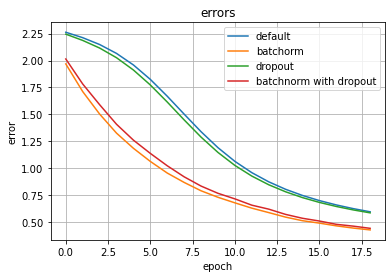

In [27]:
# отрисую
plot_graphs(test_log, 'loss')

<AxesSubplot:>

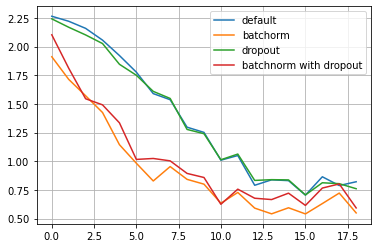

In [28]:
# отрисую train_log (plot_graphs(train_log, 'loss') не работает :( )
def df_get(df_key, data):
    train_log_list = []
    data = data
    df_key = df_key
    for el in data[df_key]:
        train_log_list.append(el[0].detach().numpy())
        df = pd.DataFrame(train_log_list)
    df.columns = [df_key]
    return df

df_default = df_get(df_key = 'default', data = train_log)
df_batchorm = df_get(df_key = 'batchorm', data = train_log)
df_dropout = df_get(df_key = 'dropout', data = train_log)
df_batchnorm_with_dropout = df_get(df_key = 'batchnorm with dropout', data = train_log)

pd.concat([df_default, df_batchorm, df_dropout, df_batchnorm_with_dropout], axis = 1).plot(grid=True)

## переобучение "излечено": увеличены батч-сайз, learning rate

# models_overfitting

In [29]:
batch_size = 16 #batch_size

In [30]:
test_data = datasets.MNIST(path, train=False,
                           download=True, transform=mnist_transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False) 

train_data = datasets.MNIST(path, train=True,
                            download=True, transform=mnist_transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [31]:
def train_set_metrics_overfitting(model):
    loss = 0.
    acc = 0.
    with torch.no_grad():
        for data, target in train_loader:
            output = model(data)
            loss += model.loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            acc += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    loss /= len(train_loader.dataset)
    acc /= len(train_loader.dataset)
    return loss, acc

In [32]:
def test_set_metrics_overfitting(model):
    loss = 0.
    acc = 0.
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            loss += model.loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            acc += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    loss /= len(test_loader.dataset)
    acc /= len(test_loader.dataset)
    return loss, acc

In [33]:
def train_overfitting(epoch, models):
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models:
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
    else:
        batch_idx += 1
        for i, model in enumerate(models):
            train_loss, train_acc = train_set_metrics_overfitting(model)
            test_loss, test_acc = test_set_metrics_overfitting(model)
            model._append_metric_value('train_loss', train_loss)
            model._append_metric_value('train_acc', train_acc)
            model._append_metric_value('test_loss', test_loss)
            model._append_metric_value('test_acc', test_acc)
            line = 'Model: {} | Train Epoch: {} | '.format(i, epoch) + \
                'Train Loss: {:.4f} | Test Loss: {:.4f} | Train Acc: {:.4f} | Test Acc: {:.4f}'.format(
                train_loss, test_loss, train_acc, test_acc)
            print(line)

In [34]:
#функция для отрисовки потерь и точности
def plot_graph_overfitting(model, metric, epochs):
    plt.title('Model fit')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    if metric == 'Loss':
        plt.plot(model.train_losses_[:epochs], color='green', label='train')
        plt.plot(model.test_losses_[:epochs], color='red', label='test')
    if metric == 'Accuracy':        
        plt.plot(model.train_accs_[:epochs], color='green', label='train')
        plt.plot(model.test_accs_[:epochs], color='red', label='test')
    plt.legend()
    plt.grid()
    plt.show() 

In [35]:
class Net_overfitting(nn.Module):
    def __init__(self, lr, log_softmax=False):
        super(Net_overfitting, self).__init__()
        lr = lr
        self.fc1 = nn.Linear(28*28, 128)
        self.fc1_1 = nn.Linear(128, 128)
        self.fc1_2 = nn.Linear(128, 256)
        self.fc1_3 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)
        self.log_softmax = log_softmax
        self.optim = optim.SGD(self.parameters(), lr = lr) #lr=1e-4*1000
        
        self.train_losses_ = []
        self.test_losses_ = []
        self.train_accs_ = []
        self.test_accs_ = []
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc1_1(x))
        x = torch.relu(self.fc1_2(x))
        x = torch.relu(self.fc1_3(x))
        x = self.fc2(x)
        if self.log_softmax:
            x = F.log_softmax(x, dim=1)
        else:
            x = torch.log(F.softmax(x, dim=1))
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss
    
    def _append_metric_value(self, metric, value):
        if metric == 'train_loss':
            self.train_losses_.append(value)
        if metric == 'test_loss':
            self.test_losses_.append(value)
        if metric == 'train_acc':
            self.train_accs_.append(value)
        if metric == 'test_acc':
            self.test_accs_.append(value)
        return self

In [36]:
#создаю модель
lr = 1e-4*100
models_overfitting = [Net_overfitting(lr = lr, log_softmax = True)]

In [37]:
# итерирование по эпохам
for epoch in range(1, ep):
    train_overfitting(epoch, models_overfitting)

Model: 0 | Train Epoch: 1 | Train Loss: 0.2308 | Test Loss: 0.2299 | Train Acc: 0.9313 | Test Acc: 0.9311
Model: 0 | Train Epoch: 2 | Train Loss: 0.1383 | Test Loss: 0.1507 | Train Acc: 0.9590 | Test Acc: 0.9524
Model: 0 | Train Epoch: 3 | Train Loss: 0.0976 | Test Loss: 0.1220 | Train Acc: 0.9706 | Test Acc: 0.9622
Model: 0 | Train Epoch: 4 | Train Loss: 0.0697 | Test Loss: 0.0989 | Train Acc: 0.9792 | Test Acc: 0.9691
Model: 0 | Train Epoch: 5 | Train Loss: 0.0593 | Test Loss: 0.0930 | Train Acc: 0.9822 | Test Acc: 0.9714
Model: 0 | Train Epoch: 6 | Train Loss: 0.0432 | Test Loss: 0.0832 | Train Acc: 0.9875 | Test Acc: 0.9734
Model: 0 | Train Epoch: 7 | Train Loss: 0.0416 | Test Loss: 0.0897 | Train Acc: 0.9873 | Test Acc: 0.9738
Model: 0 | Train Epoch: 8 | Train Loss: 0.0361 | Test Loss: 0.0867 | Train Acc: 0.9891 | Test Acc: 0.9733
Model: 0 | Train Epoch: 9 | Train Loss: 0.0287 | Test Loss: 0.0848 | Train Acc: 0.9911 | Test Acc: 0.9732
Model: 0 | Train Epoch: 10 | Train Loss: 0.020

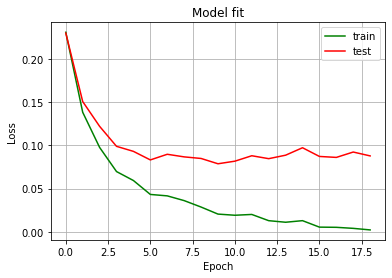

In [38]:
# отрисую
plot_graph_overfitting(models_overfitting[0], 'Loss', 100)

# вывод: 
 - lerning rate влияет на скорость обучения и может привести к переобучению
 - батч-нормализация, регуляризация помогают в профилактике переобучения
 - добавление числа слоев может привести к переобучению, но также и к необучению, затухание градиента
 - также на качество влияет размер батча

## использовал lerning rate + батч-нормализация, регуляризация + число слоев получил переобучение